## Samsung Traffic Volume Growth
Samsung devices are the main handsets in our network. Can you predict the traffic volume growth, uplink and downlink, over time for these devices and compare it to the competitors?

In [1]:
# Setup Libraries
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import xgboost
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import learning_curve

In [37]:
# Setup Dataset Path
DATA_PATH = '../data/processed/RSRP_Traffic.parquet'

In [38]:
#Load Data
df = pd.read_parquet(DATA_PATH)

In [39]:
df.head(1)

,Timestamp,LocationLatitude,LocationLongitude,RadioConnectionType,RadioNetworkGeneration,RSRP,RadioMobileDataEnabled,DeviceManufacturer,DeviceName,time_approxmate,Average_RSRP,TrafficDirection,TrafficVolume
0,2019-11-02 01:39:40,24.691517,46.65258,Mobile,4G,-94,Enabled,HUAWEI,Huawei Y5 2019,2019-11-02 01:45:00,-93.444444,Downlink,6.218721


In [40]:
df = df[['Timestamp','LocationLatitude','LocationLongitude','DeviceManufacturer', 'DeviceName','TrafficDirection','TrafficVolume']]
df.head(1)

,Timestamp,LocationLatitude,LocationLongitude,DeviceManufacturer,DeviceName,TrafficDirection,TrafficVolume
0,2019-11-02 01:39:40,24.691517,46.65258,HUAWEI,Huawei Y5 2019,Downlink,6.218721


In [41]:
#Extract Samsung Data
snap_samsung = df[df['DeviceManufacturer']=='samsung'].drop(['DeviceManufacturer'],axis=1)
snap_samsung.head(2)

,Timestamp,LocationLatitude,LocationLongitude,DeviceName,TrafficDirection,TrafficVolume
20,2019-11-02 09:04:25,24.751925,46.8578,Galaxy On7 Prime,Uplink,0.997738
21,2019-11-02 09:04:25,24.751925,46.8578,Galaxy On7 Prime,Downlink,7.808209


In [42]:
#snap_samsung = df.groupby(by=['Timestamp','TrafficDirection','DeviceName'])['TrafficVolume'].mean().reset_index()
#snap_samsung.head()

<AxesSubplot:ylabel='Frequency'>

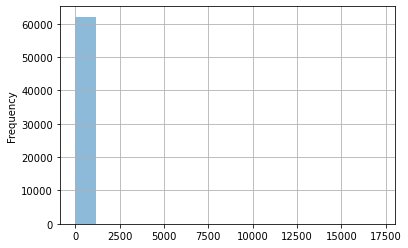

In [43]:
snap_samsung['TrafficVolume'].plot.hist(alpha=0.5, bins=15, grid=True, legend=None)

<AxesSubplot:ylabel='Frequency'>

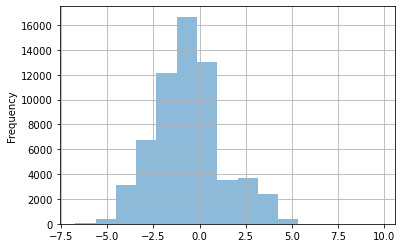

In [44]:
snap_samsung['TrafficVolume_log'] = [np.log(x) for x in snap_samsung['TrafficVolume']]
snap_samsung['TrafficVolume_log'].plot.hist(alpha=0.5, bins=15, grid=True, legend=None)

In [45]:
snap_samsung['Hour'] = snap_samsung['Timestamp'].dt.hour
snap_samsung['Mintue'] = snap_samsung['Timestamp'].dt.minute
snap_samsung = snap_samsung[['Hour','Mintue','DeviceName','LocationLatitude','LocationLongitude','TrafficDirection','TrafficVolume_log']]
snap_samsung.head(1)

,Hour,Mintue,DeviceName,LocationLatitude,LocationLongitude,TrafficDirection,TrafficVolume_log
20,9,4,Galaxy On7 Prime,24.751925,46.8578,Uplink,-0.002265


In [46]:
#One Hot encoding
snap_samsung=pd.concat([snap_samsung,pd.get_dummies(snap_samsung['TrafficDirection'], drop_first=True, prefix='TrafficDirection')],axis=1).drop(['TrafficDirection'],axis=1)
snap_samsung=pd.concat([snap_samsung,pd.get_dummies(snap_samsung['DeviceName'], drop_first=True, prefix='DeviceName')],axis=1).drop(['DeviceName'],axis=1)
snap_samsung.head(1)

,Hour,Mintue,LocationLatitude,LocationLongitude,TrafficVolume_log,TrafficDirection_Uplink,DeviceName_Galaxy A10S,DeviceName_Galaxy A20,DeviceName_Galaxy A20S,DeviceName_Galaxy A30,...,DeviceName_Galaxy S5,DeviceName_Galaxy S5 Dual Sim,DeviceName_Galaxy S6 Edge,DeviceName_Galaxy S6 Edge+,DeviceName_Galaxy S7,DeviceName_Galaxy S7 Edge,DeviceName_Galaxy S8,DeviceName_Galaxy S8+,DeviceName_Galaxy S9,DeviceName_Galaxy S9+
20,9,4,24.751925,46.8578,-0.002265,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# Get the feature values until the target column (not included)
X = snap_samsung.drop(['TrafficVolume_log'],axis=1).values.astype(np.float32)

# Get the target column
y = snap_samsung['TrafficVolume_log'].values.astype(np.float32)

In [48]:
# Get 80% of the data for training; the remaining 20% will be for validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"Length of train_features is: {X_train.shape}")
print(f"Length of train_labels is: {y_train.shape}")
print(f"Length of test_features is: {X_test.shape}")
print(f"Length of test_labels is: {y_test.shape}")

Length of train_features is: (49714, 64)
Length of train_labels is: (49714,)
Length of test_features is: (12429, 64)
Length of test_labels is: (12429,)


In [49]:
#xgb
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)
y_xgb_predicted = xgb.predict(X_test)

In [50]:
mae_xgb = metrics.mean_absolute_error(y_test, y_xgb_predicted)
mse_xgb = metrics.mean_squared_error(y_test, y_xgb_predicted)
r2_xgb  = metrics.r2_score(y_test, y_xgb_predicted)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae_xgb ))
print('MSE is {}'.format(mse_xgb ))
print('R2 score is {}'.format(r2_xgb))

The model performance for testing set
--------------------------------------
MAE is 0.5965806841850281
MSE is 0.8531978130340576
R2 score is 0.7486401713554709
